In [1]:
import random
import numpy as np
import pandas as pd
#import tracemalloc
#tracemalloc.start()
random.seed(3311791)
np.random.seed(3311791)
df = pd.read_csv('/kaggle/input/df-lemma-clean/df_lemma_dropped.csv').drop('H', axis=1)[['Number.of.Forward.Citations','Year']]
df = df[(df['Year'] >= 2017) & (df['Year'] <= 2024)] 

df_time_period=df
#df['Year'] = df['Year'].astype(int)

In [2]:
df.columns

Index(['Number.of.Forward.Citations', 'Year'], dtype='object')

In [3]:
!pip install BorutaShap

from BorutaShap import BorutaShap
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=0, n_jobs=-1, max_depth=5) # shallower trees = save time + less risk of overfitting / try several max_depths and report in a footnote/appendix (https://stats.stackexchange.com/questions/599446/why-is-recommended-depth-of-boruta-random-forest-between-3-and-7)
    
def run_BorutaShap(df, n_try, perc=99): 

    y = df['Number.of.Forward.Citations']#.reset_index(drop=True)# drop true necessary? #[(df['Year'] >= start) & (df['Year'] <= stop)]['Number.of.Forward.Citations']
    X = pd.read_csv('/kaggle/input/2017-2023/cluster_noise_control_dummy_2017_2023.0.csv').drop('Unnamed: 0', axis=1)
    print(f'Shape of X: {X.shape}')

    Feature_Selector_shap = BorutaShap(model=rf, importance_measure='shap',
                                  classification=False, percentile=perc)
    Feature_Selector_shap.fit(X=X, y=y, n_trials=n_try, sample=True, 
                          train_or_test = 'train', normalize=True,
                verbose=False, random_state=0)
    Feature_Selector_shap.TentativeRoughFix()
    return Feature_Selector_shap

Analyzing years 2017 - 2023.0...
Shape of X: (23651, 27067)


  0%|          | 0/50 [00:00<?, ?it/s]

0 tentative features are now accepted: []
32 tentative features are now rejected: ['cartridge+set information' 'instrument+lockout member'
 'cartridge+reader' 'Family.Number_57411648' 'cluster_160' 'cluster_1078'
 'cluster_354' 'cluster_444' 'cluster_424' 'Family.Number_65498122'
 'Probable.Patent.Assignee_GRAPHENE PLATFORM CORP'
 'Family.Number_62235056' 'cluster_949' 'cluster_85' 'B' 'cluster_189'
 'Family.Number_70854265' 'cluster_598' 'cluster_1104' 'Country.Code_WO'
 'control+instrument' 'Probable.Patent.Assignee_STOREDOT LTD'
 'Family.Number_74866509' 'identification scanner+radio identification'
 'cluster_1124' 'cluster_737' 'cluster_1183' 'cluster_1149'
 'Family.Number_59098979' 'cluster_1350' 'Family.Number_82755284'
 'Family.Number_67173459']
BorutaShap took 20861.048780202866 seconds


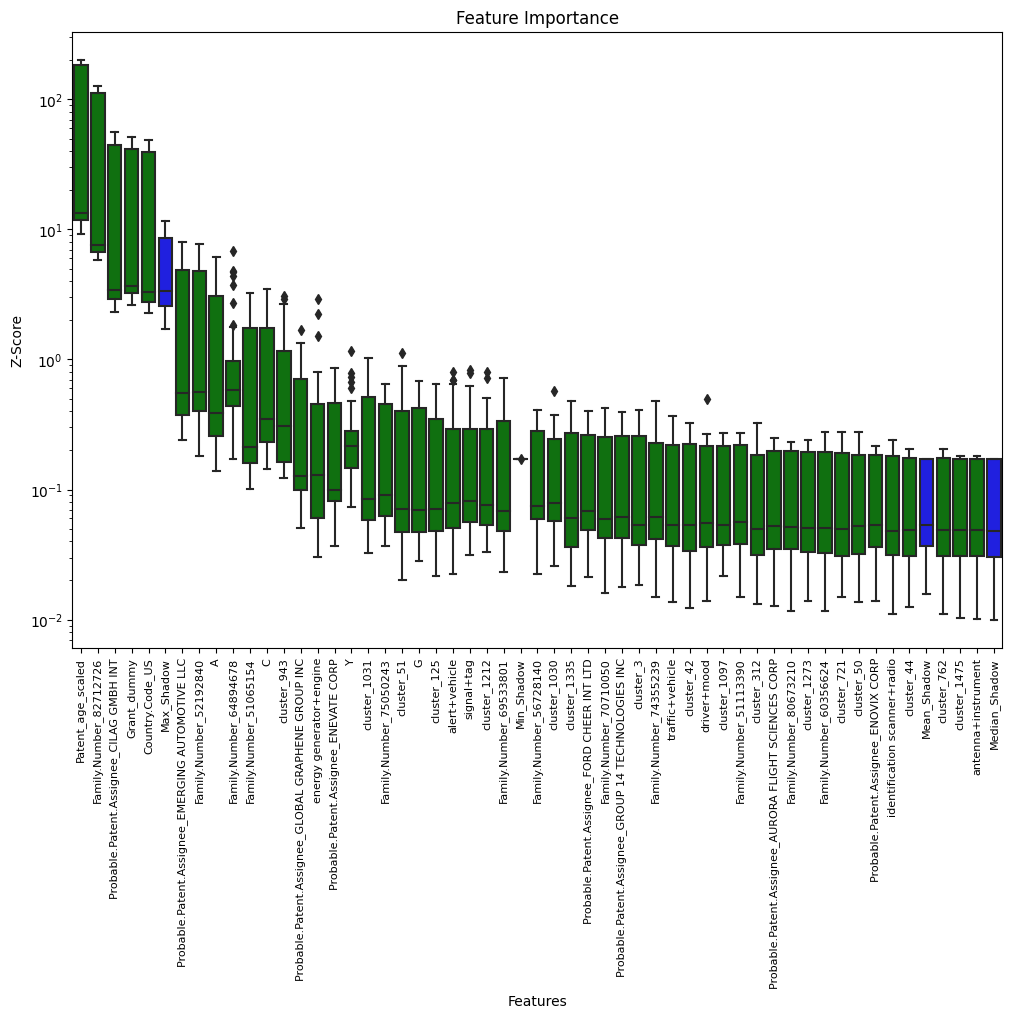

In [6]:
#2017-2023
import time
from sklearn.preprocessing import StandardScaler
import csv
import ast

def main(df, time_periods=[(1990,1991)], start=None, stop=None, max_df=0.50, max_feat=None, min_patent_cooc=2, tfidf_threshold_percentile=99, min_cluster_size=2, n_components=50, n_try=60):
    '''
    Main function: outputs csv files from BorutaShap and sentences of most important co-occurrences as a xlsx file
    '''
    scaler = StandardScaler()
    results = []
    filenames = []

    
    for i, (start, stop) in enumerate(time_periods):
        #BorutaShap importances
        start_time = time.time()
        Feature_Selector_shap = run_BorutaShap(df=df_time_period, perc=99, n_try=n_try)
        print(f'BorutaShap took {time.time() - start_time} seconds')
        #del cluster_noise_control_dummy

        Feature_Selector_shap.plot(which_features='accepted')
        filename = f'feature_importance_{start}_to_{stop}'

        Feature_Selector_shap.results_to_csv(filename=filename)

time_periods = [(2017, float(max(df['Year'])))] 
for start, stop in time_periods:
    print(f'Analyzing years {start} - {stop}...')
    main(df, time_periods=[(start, stop)], max_df=0.5, max_feat=None, tfidf_threshold_percentile=99, n_components=2, n_try=50)
